<a href="https://colab.research.google.com/github/letpires/bootcamp_alura/blob/main/Projeto_final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

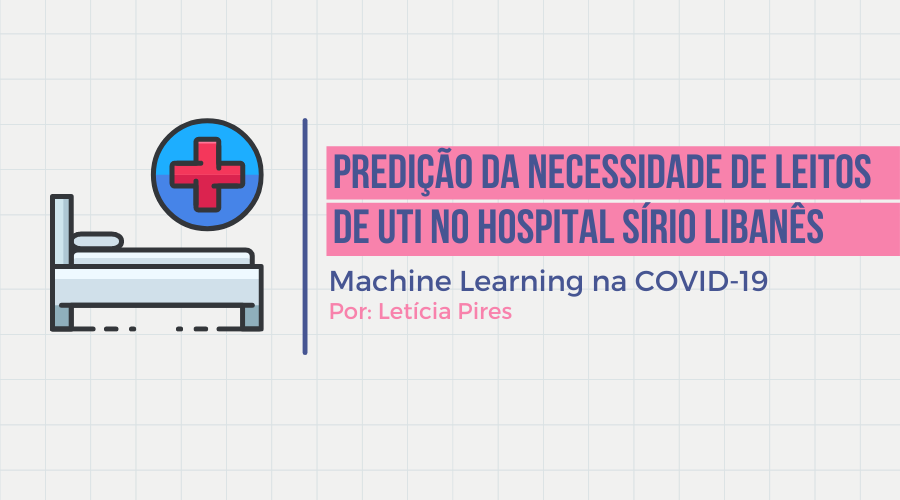

#**CONTEXTO**

A pandemia de COVID-19 atingiu o mundo inteiro, sobrecarregando os sistemas de saúde - despreparados para uma solicitação tão intensa e demorada de leitos de UTI, profissionais, equipamentos de proteção individual e recursos de saúde.
O Brasil registrou o primeiro caso COVID-19 em 26 de fevereiro e atingiu a transmissão na comunidade em 20 de março.

###**Problemática**

Há urgência na obtenção de dados precisos para melhor prever e preparar os sistemas de saúde e evitar colapsos, definido pela necessidade de leitos de UTI acima da capacidade (assumindo que recursos humanos, EPIs e profissionais estejam disponíveis), usando dados clínicos individuais - em vez de dados epidemiológicos e populacionais .

###**Objetivo** 

Criar um modelo de Machine Learning capaz de ajudar os médicos e enfermeiros do Hospital Sírio-Libanês a prever quais pacientes precisarão ser admitidos na unidade de terapia intensiva (UTI) devido a complicações da COVID-19 e, assim, definir qual a necessidade de leitos de UTI do Hospital a partir dos dados clínicos individuais disponíveis. 

Portanto, nosso modelo deve ser capaz de classificar se um paciente irá (1) ou não irá (0) para UTI, que é a nossa variável-alvo.

###**Tarefas** 

**Informações e dicas passadas pelo próprio Hospital e que serão seguidas para construção do modelo:**

1. Prever quais pacientes necessitarão de UTI;
2. Prever quais pacientes NÃO necessitarão de UTI.

###**Variável de interesse e Janela:**

- UTI ou não - ICU - (0,1);
- Janela de tempo - WINDOW - ['0-2', '2-4', '6-12', 'Above-12');

###**Critérios obrigatórios**
Não utilizar os dados quando o paciente deu entrada na UTI -> ICU = 1, pois estes já terão ido diretamente para a UTI nas 2 primeiras horas, não importando para a predição.

###**Aspectos dos dados**
Os dados foram anonimizados e escalados para manterem-se entre 0 e 1;

###**Entendendo as variáveis disponíveis:**

- Informações demgráficas (03);
- Agrupamento de doenças (09);
- Resultados de exames de sangue (36);
- Sinais vitais (06).

Diversas variáveis foram expandidas para versões média, mediana, máximo, mínimo, diff e diff relativo.

diff = valor máximo - valor mínimo;
diff relativo = diff / mediana

###**Estrutura de Dados:**

Neste banco de dados temos pacientes positivos para COVID-19 internados no Hospital Sírio Libânes de São Paulo-SP e Brasília-DF. De forma geral, temos até 5 entradas que representam dados de um mesmo paciente. Essas entradas são referentes à diferentes janelas de tempo (0-2, 2-4, 4-6, 6-12, >12) em que os pacientes foram acompanhados. Para cada uma das janelas, foram dosados diversos marcadores biológicos e sinais vitais.

Resumidamente, o layout dos dados estruturados e a estrutura do banco  é a seguinte:



**Tabela 1. Layout do dados e Estrutura de repetição dos dados no banco usado no desafio.**

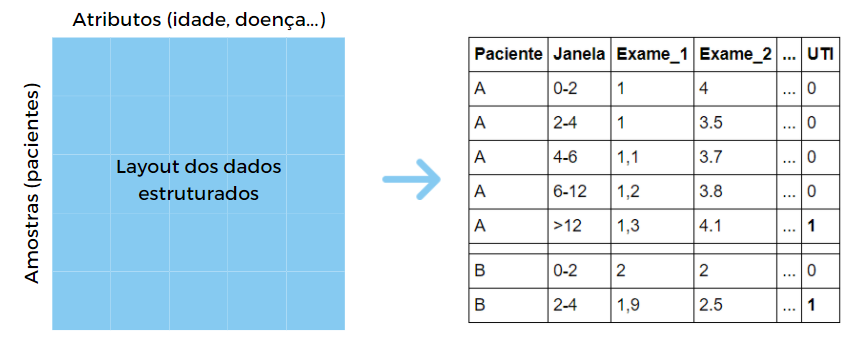

##**Referência/Recomendação**

Utilizei como base para criação dos modelos de ML e validação dos mesmos, o livro "Machine Learning: Guia de Referência Rápida - Trabalhando com dados estruturados em Python", de Matt Harrison e as aulas do Bootcamp.

#**ETAPAS DO PROJETO:**

No livro "Machine Learning: guia de referência rápida", o autor Matt Harrison, apresenta uma visão geral do processo de machine learning, desde a importação de bibliotecas até a implantação do modelo. Uni a leitura do livro com as aulas do Bootcamp e montei meu fluxo/roteiro pra implantação do modelo, como mostra a figura abaixo:

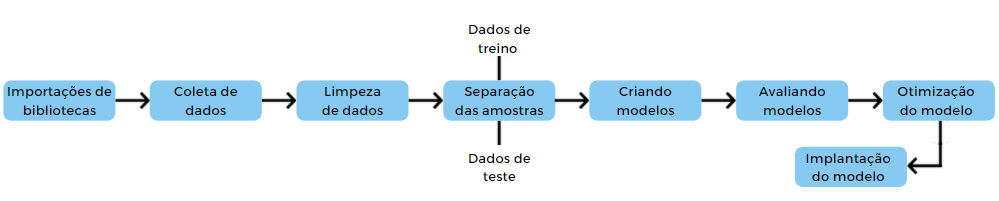

#**1. IMPORTAÇÕES** 

Foi importado as bibliotecas utilizadas neste notebook para desenvolvimento e tratamento dos dados:

In [74]:
# Bibliotecas básicas para análise e visualização de dados
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Bibliotecas de modelos de Machine Learning (ML)
from sklearn.metrics import (plot_confusion_matrix, classification_report,
                             roc_auc_score, accuracy_score, 
                             plot_confusion_matrix)
from sklearn.model_selection import (cross_validate, StratifiedKFold, 
                                     RepeatedStratifiedKFold, train_test_split)
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.dummy import DummyClassifier

# Biblioteca de métricas para análise do modelo ML
from yellowbrick.classifier import ROCAUC
from yellowbrick.model_selection import (ValidationCurve, LearningCurve) 
from yellowbrick.features.importances import FeatureImportances
from yellowbrick.classifier import ClassBalance

# Biblioteca para controle de warnings
import warnings
warnings.filterwarnings('ignore')

# **2. COLETA DE DADOS**

A base de dados da Covid-19 foi disponibilizada pelo Hospital Sírio Libanês - São Paulo e Brasília, no Kaggle, através da equipe do Bootcamp. Você pode conferir a base dados também [nesse link](https://www.kaggle.com/S%C3%ADrio-Libanes/covid19).

In [75]:
dados = pd.read_excel("https://github.com/letpires/bootcamp_alura/blob/main/modulo_final/Kaggle_Sirio_Libanes_ICU_Prediction.xlsx?raw=true")
dados.head()

,PATIENT_VISIT_IDENTIFIER,AGE_ABOVE65,AGE_PERCENTIL,GENDER,DISEASE GROUPING 1,DISEASE GROUPING 2,DISEASE GROUPING 3,DISEASE GROUPING 4,DISEASE GROUPING 5,DISEASE GROUPING 6,HTN,IMMUNOCOMPROMISED,OTHER,ALBUMIN_MEDIAN,ALBUMIN_MEAN,ALBUMIN_MIN,ALBUMIN_MAX,ALBUMIN_DIFF,BE_ARTERIAL_MEDIAN,BE_ARTERIAL_MEAN,BE_ARTERIAL_MIN,BE_ARTERIAL_MAX,BE_ARTERIAL_DIFF,BE_VENOUS_MEDIAN,BE_VENOUS_MEAN,BE_VENOUS_MIN,BE_VENOUS_MAX,BE_VENOUS_DIFF,BIC_ARTERIAL_MEDIAN,BIC_ARTERIAL_MEAN,BIC_ARTERIAL_MIN,BIC_ARTERIAL_MAX,BIC_ARTERIAL_DIFF,BIC_VENOUS_MEDIAN,BIC_VENOUS_MEAN,BIC_VENOUS_MIN,BIC_VENOUS_MAX,BIC_VENOUS_DIFF,BILLIRUBIN_MEDIAN,BILLIRUBIN_MEAN,...,DIMER_MAX,DIMER_DIFF,BLOODPRESSURE_DIASTOLIC_MEAN,BLOODPRESSURE_SISTOLIC_MEAN,HEART_RATE_MEAN,RESPIRATORY_RATE_MEAN,TEMPERATURE_MEAN,OXYGEN_SATURATION_MEAN,BLOODPRESSURE_DIASTOLIC_MEDIAN,BLOODPRESSURE_SISTOLIC_MEDIAN,HEART_RATE_MEDIAN,RESPIRATORY_RATE_MEDIAN,TEMPERATURE_MEDIAN,OXYGEN_SATURATION_MEDIAN,BLOODPRESSURE_DIASTOLIC_MIN,BLOODPRESSURE_SISTOLIC_MIN,HEART_RATE_MIN,RESPIRATORY_RATE_MIN,TEMPERATURE_MIN,OXYGEN_SATURATION_MIN,BLOODPRESSURE_DIASTOLIC_MAX,BLOODPRESSURE_SISTOLIC_MAX,HEART_RATE_MAX,RESPIRATORY_RATE_MAX,TEMPERATURE_MAX,OXYGEN_SATURATION_MAX,BLOODPRESSURE_DIASTOLIC_DIFF,BLOODPRESSURE_SISTOLIC_DIFF,HEART_RATE_DIFF,RESPIRATORY_RATE_DIFF,TEMPERATURE_DIFF,OXYGEN_SATURATION_DIFF,BLOODPRESSURE_DIASTOLIC_DIFF_REL,BLOODPRESSURE_SISTOLIC_DIFF_REL,HEART_RATE_DIFF_REL,RESPIRATORY_RATE_DIFF_REL,TEMPERATURE_DIFF_REL,OXYGEN_SATURATION_DIFF_REL,WINDOW,ICU
0,0,1,60th,0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,0.086420,-0.230769,-0.283019,-0.593220,-0.285714,0.736842,0.086420,-0.230769,-0.283019,-0.586207,-0.285714,0.736842,0.237113,0.0000,-0.162393,-0.500000,0.208791,0.898990,-0.247863,-0.459459,-0.432836,-0.636364,-0.420290,0.736842,-1.00000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,0-2,0
1,0,1,60th,0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,0.333333,-0.230769,-0.132075,-0.593220,0.535714,0.578947,0.333333,-0.230769,-0.132075,-0.586207,0.535714,0.578947,0.443299,0.0000,-0.025641,-0.500000,0.714286,0.838384,-0.076923,-0.459459,-0.313433,-0.636364,0.246377,0.578947,-1.00000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,2-4,0
2,0,1,60th,0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.605263,0.605263,0.605263,0.605263,-1.0,-1.000000,-1.000000,-1.000000,-1.000000,-1.0,-1.000000,-1.000000,-1.000000,-1.000000,-1.0,-0.317073,-0.317073,-0.317073,-0.317073,-1.0,-0.317073,-0.317073,-0.317073,-0.317073,-1.0,-0.938950,-0.938950,...,-0.994912,-1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4-6,0
3,0,1,60th,0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,-0.107143,0.736842,NaN,NaN,NaN,NaN,-0.107143,0.736842,NaN,NaN,NaN,NaN,0.318681,0.898990,NaN,NaN,NaN,NaN,-0.275362,0.736842,NaN,NaN,NaN,NaN,-1.000000,-1.000000,NaN,NaN,NaN,NaN,-1.000000,-1.000000,6-12,0
4,0,1,60th,0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.000000,0.000000,0.000000,0.000000,-1.0,-0.871658,-0.871658,-0.871658,-0.871658,-1.0,-0.863874,-0.863874,-0.863874,-0.863874,-1.0,-0.317073,-0.317073,-0.317073,-0.317073,-1.0,-0.414634,-0.414634,-0.414634,-0.414634,-1.0,-0.979069,-0.979069,...,-0.996762,-1.0,-0.243021,-0.338537,-0.213031,-0.317859,0.033779,0.665932,-0.283951,-0.376923,-0.188679,-0.379310,0.035714,0.631579,-0.340206,-0.4875,-0.572650,-0.857143,0.098901,0.797980,-0.076923,0.286486,0.298507,0.272727,0.362319,0.947368,-0.33913,0.325153,0.114504,0.176471,-0.238095,-0.818182,-0.389967,0.407558,

#**3. FUNÇÕES** 

Abaixo seguem as funções utilizadas para limpeza dos dados, criação de modelos e validação com métricas.

In [83]:
def resume_data(dataset  : pd.DataFrame):
  data_nan = dataset.isnull().any().any() #retorno os dados Not a Number das colunas
  dataset_types = list (set(dataset.dtypes.values)) #com o set realizo um "filtro" removendo dados repetidos
  print("RESUMO DOS DADOS:\n")
  #shape nos retorna uma tupla com dois valores, sendo um referente a linhas e o outro a coluna, respectivamente.
  print(f"Quantidade de amostras: {dataset.shape[0]} (linhas)\nQuantidade de Atributos: {dataset.shape[1]} (colunas)\n")

  if data_nan:
    print(f"Possui dados NaN ? {data_nan}\nQuantidade de NaN totais: {dataset.isnull().sum().values.sum()}\n")
  else:
    print("Não há dados ausentes neste dataset\n")

  print(f"Tipos de  dados que temos :\n{dataset_types}\n")

## 3.1 Funções para limpeza de dados

In [77]:
'''
Função que agrupa todos os grupos de dados de um paciente e atribui o valor 
ICU==1 na janela de até 2 horas.
'''

def prepare_window(rows):
    if(np.any(rows["ICU"])):
        rows.loc[rows["WINDOW"]=="0-2", "ICU"] = 1
    return rows.loc[rows["WINDOW"] == "0-2"]

In [78]:
'''
Função que agrupa cada valor da coluna PATIENT_VISIT_IDENTIFIER e 
preenche os dados faltantes das variáveis contínuas através do método 
bfill e ffill
'''

def fill_table(data):

    #Features_continuas contem grande parte das colunas de dados e NaN
    features_continuas_colunas = data.iloc[:, 13:-2].columns
    features_continuas = data.groupby("PATIENT_VISIT_IDENTIFIER", 
                                      s_index=False)
                                      [features_continuas_colunas].fillna(method='bfill').fillna(method='ffill')
    #Features_categoricas contem as 13 primeiras colunas do dataframe
    features_categoricas = data.iloc[:, :13]
    #Saida contém as duas últimas colunas WINDOW e ICU
    saida = data.iloc[:, -2:]
    dados_finais = pd.concat([features_categoricas, features_continuas, saida], ignore_index=True,axis=1)
    dados_finais.columns = data.columns
    return dados_finais

A função abaixo consiste em uma técnica elaborada pelo Thiago Gonçalves e Alan Spadinni nas aulas do Módulo 6, que consiste na criação de correlação de todas as linhas a partir da quarta coluna e antepenúltima (sem considerar `WINDOW` e `ICU`). Em seguida é gerado uma correlação e transformação dos valores para absoluto (não negativos). 

"A correlação vai de -1 a 1. Altas correlações aproximam de -1 e +1. Quando é próxima de -1 ocorre o inverso, então uma variável cresce e outra sobre. Quando é próxima de +1, é proporcional, quando uma sobre a outra também sobe."

Em seguida o `any` busca dentro dentro da matriz de correlação variáveis com alta correlação (valores acima do valor_corte) e através do laço `for`, isso é repetido pra todas as colunas. E caso seja verdadeiro, fica armazenado dentro de uma lista.

No entanto, fazendo somente essas ações não é possível, visto que, todas as colunas seriam excluídas. Por isso, podemos observar através da figura abaixo que a coluna na diagonal é igual a 1, e o triângulo superior é um espelho do inferior. Sendo assim, aplicando o `where`, `np.ones`(matriz com 1s) e `np.triu`(elimina triângulo abaixo da diagonal igual a 1).



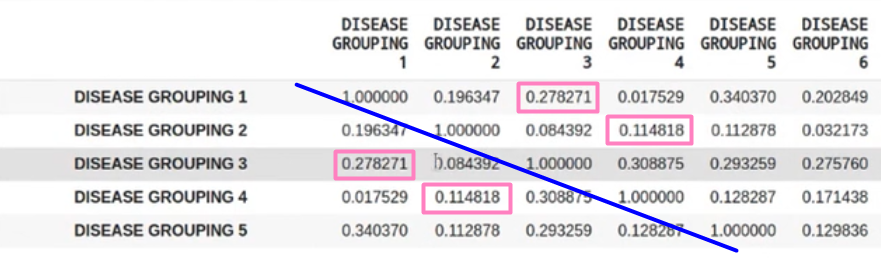

Acima temos a matriz de dados correlacionada, onde a linha azul mostra a diagonal com valor sempre igual a 1, pois são as mesmas colunas refletidas uma na outras. Abaixo dessa linha azul tenho o triângulo inferior, que como podemos ver pelo retângulo em rosa, representa o espelhamento do triângulo superior.

In [80]:
'''
Função que analisa a correlação entre as variáveis do banco de dados, cria uma
máscara para remover os dados espelhados e retorna os dados sem as variáveis 
com correlação maior que o valor de corte 0.95.
'''

def remove_corr_var(dados, valor_corte = 0.95):

  matriz_corr = dados.iloc[:,4:-2].corr().abs()
  matriz_superior = matriz_corr.where(np.triu(np.ones(matriz_corr.shape), k=1).astype(np.bool))
  excluir = [coluna for coluna in matriz_superior.columns if any(matriz_superior[coluna]> valor_corte)]
  
  return dados.drop(excluir, axis=1)


## 3.2 Funções para modelos de ML e métricas

In [85]:
'''
Função que recebe conjunto de dados e divide em dados de treino e dados de 
teste.
'''
def criar_treino_teste(dataset):
  np.random.seed(727356)
  x_columns = dataset.columns
  y = dataset["ICU"]
  x = dataset[x_columns].drop(["ICU","PATIENT_VISIT_IDENTIFIER"], axis=1)
  x_train, x_test, y_train, y_test = train_test_split(x, y, stratify=y)

  return  x_train, x_test, y_train, y_test

In [79]:
'''
Função que retorna o valor AUC gerado pelo modelo que passamos e o 
Classification Report que contém informações importantes de métricas, como
precisão, recall e f1-score.
'''

def roda_modelo(modelo, dados):
  
  x_columns = dados.columns
  #dados de resposta
  y = dados["ICU"]
  #dados de entrada
  x = dados[x_columns].drop(["ICU","WINDOW"], axis=1)

  #criando variáveis de treino e teste
  x_train, x_test, y_train, y_test = train_test_split(x, y, stratify=y)

  #treinando o modelo
  modelo.fit(x_train, y_train)
  #predizendo o modelo
  predicao = modelo.predict(x_test)
  #método de predição probabilistica importante para medir o AUC
  prob_predict = modelo.predict_proba(x_test)

  auc = roc_auc_score(y_test, prob_predict[:,1])
  print(f"AUC {auc}")
  print("\nClassification Report")
  print(classification_report(y_test, predicao))

In [82]:
'''
A função faz a separação de dados de treino e teste n vezes para diminuir o 
efeito de aleatoriedade gerado quando roda o modelo inúmeras vezes. Então deve 
ser passado o modelo, os dados e n (número de vezes que será rodado o modelo). 
Quanto maior o n, menor a aleatoriedade. Todas essas vezes são armazenadas numa 
lista. 
També é calculado o desvio padrão junto com o AUC. Fazendo a média +/- 2xstd, 
tem chance de 95% do resultado apresentar-se mais dentro da realidade.
Essa função será passada inicialmente a 4 modelos para verificar sua eficácia.
'''

def roda_n_modelos(modelo, dados, n):
  
  x_columns = dados.columns
  y = dados["ICU"]
  x = dados[x_columns].drop(["ICU","WINDOW"], axis=1)

  auc_lista = []

  # _ é utilizado como padrão, variável que não vamos utilizar os valores dados pela iteração
  for _ in range(n):
    
    x_train, x_test, y_train, y_test = train_test_split(x, y, stratify=y)

    modelo.fit(x_train, y_train)
    prob_predict = modelo.predict_proba(x_test)
    auc = roc_auc_score(y_test, prob_predict[:,1])
    auc_lista.append(auc)

  auc_medio = np.mean(auc_lista)
  auc_std = np.std(auc_lista)
  print(f"AUC médio =  {auc_medio}")
  print(f"Intervalo {auc_medio - 2* auc_std} - {auc_medio  + 2*auc_std}")

Essa função realiza o processo de split dos daddos, realizando primeiramente um embaralhamento nos dados para que possamos ter uma aleatoriedade de dados que simule um processo real. Depois realizamos as divisões no conjunto de dados para teste e treino. Com o auxilio do RepeatedStratifiedKFold iremos embaralhar, fatiar e repetir este processos  k  numero de vezes que forem adequadas.
Iremos ainda aplicar o cross_validate para realizar o cruzamento destes dados. Ele irá seus resultados no formato de dicionário, do qual printaremos uma média tanto para o score_test, train_score, que são as respectivas pontuações de teste e treino, assim como o desvio padrão gerado pelo test_score

In [81]:
'''
Função que separa os dados de treino e teste e com o Repeated
https://minerandodados.com.br/validacao-cruzada-aprenda-de-forma-simples-como-usar-essa-tecnica/ EXPLICAR
'''

def roda_modelo_cv(modelo, dados, n_splits, n_repeats):
  
  np.random.seed(1231234)
  dados = dados.sample(frac=1).reset_index(drop=True)
  x_columns = dados.columns
  y = dados["ICU"]
  x = dados[x_columns].drop(["ICU","WINDOW"], axis=1)

  cv = RepeatedStratifiedKFold(n_splits = n_splits, n_repeats=n_repeats)
  resultados = cross_validate(modelo, x, y, cv=cv, scoring='roc_auc', return_train_score=True)

  auc_medio = np.mean(resultados['test_score'])
  auc_medio_treino = np.mean(resultados['train_score'])

  auc_std = np.std(resultados['test_score'])
  
  print(f"AUC {auc_medio} - {auc_medio_treino}")
  return auc_medio, auc_medio_treino

In [84]:
def plote_confusion_matrix(dados, modelo):
  x_train,x_test,y_train,y_test = criar_treino_teste(dados)
  modelo.fit(x_train,y_train)
  predicao_dados = modelo.predict(x_test)


  fig, ax = plt.subplots(figsize=(7,7))

  figure = plot_confusion_matrix(modelo, x_test, y_test, ax=ax, cmap="PuBu", display_labels=['Não deve \n internar','Deve \n internar'])

  ax.set_title("Confusion matrix\n(Normalized values)", fontsize=16, fontweight="bold")
  ax.set_xlabel("Predicted label", fontsize=18)
  ax.set_ylabel("True label", fontsize=18)



In [86]:
def balanceamento_classes(dados):
  np.random.seed(165488)
  
 
  x_train, x_test, y_train, y_test = criar_treino_teste(dados)

  fig,ax = plt.subplots(figsize=(12,6))
  cb_viz=ClassBalance(labels=["Internado", "Não internado"])

  cb_viz.fit(y_test)
  cb_viz.poof()

In [87]:
def plotar_roc_auc(modelo,dados,name_dataset):
  np.random.seed(165488)
  
 
  x_train, x_test, y_train, y_test = criar_treino_teste(dados)
  #Separamos os dados de treino e teste

  #treinamos
  modelo.fit(x_train, y_train)
  #predizemos 
  predicao = modelo.predict(x_test)
  #plotamos a figura na qual ROCAUC irá realizar os calculos, pedindo apenas que
  #passemos o modelo
  fig, aux = plt.subplots(figsize=(9,9))
  roc_viz = ROCAUC(modelo)
  #realizamos também os calculos de pontuação que são apresentados na legenda do gráfico
  roc_viz.score(x_test,y_test)
  plt.legend()
  plt.title(f"Curva ROC para {name_dataset} - MODELO {modelo.__class__.__name__}")
  plt.show()

In [88]:
def validation_curve(modelo,dados,n_range_max, param):
  np.random.seed(165488)
  
 
  x_train, x_test, y_train, y_test = criar_treino_teste(dados)
  #Separamos os dados de treino e teste

  
  fig, aux = plt.subplots(figsize=(9,9))
  vc_viz = ValidationCurve(modelo, param_name=param, param_range=np.arange(11, n_range_max), cv=10, n_jobs=-1)

  vc_viz.fit(x_train,y_train)
  vc_viz.poof()

In [89]:
def learning_curve(modelo, dados):
  np.random.seed(165488)
  
 
  x_train, x_test, y_train, y_test = criar_treino_teste(dados)

  fig,ax = plt.subplots(figsize=(12,6))
  lc3_viz=LearningCurve(modelo, cv=10)

  lc3_viz.fit(x_train,y_train)
  lc3_viz.poof()


In [90]:
def plotar_FeatureImportances (dados, modelo):
  x_train,x_test,y_train,y_test = criar_treino_teste(dados)
  modelo.fit(x_train,y_train)
  predicao_dados = modelo.predict(x_test)
  #depois de separado os dados de treino e teste e depois dos treinamentos e predições
  #criamos um grafico
  fig,ax = plt.subplots(figsize=(15,35))
  #passamos o modelo que irá ser usados para detectar as colunas "mais importantes"
  fi_viz = FeatureImportances(modelo)
  #realizamos um teste com as configurações instanciadas na variável anterior
  fi_viz.fit(x_test,y_test)
  #mostramos
  fi_viz.poof()

In [92]:
def acuracia (dados, modelo):
  x_train,x_test,y_train,y_test = criar_treino_teste(dados)
  modelo.fit(x_train,y_train)
  predicao_dados = modelo.predict(x_test)
  #separa-se os dados aqui para evitar erros externos.
  print(f"A acurácia do Modelo Logístico para dados_limpos é de : {(accuracy_score(y_test, predicao_dados))*100 :.2f} %")

# **4. LIMPEZA DOS DADOS**

Antes de aplicar os modelos é necessário preparar os nossos dados. Os modelos de ML não aceitam por exemplo strings. Então precisamos deixar os dados em numéricos e/ou categóricos.

Inicialmente vamos passar a função `fill_table` para agrupar a coluna `PATIENT_VISIT_IDENTIFIER` e preencher dados faltantes. Em seguida, realizou-se uma `query` por todas as colunas/linhas que possuem `WINDOW=='0-2'` and `ICU==1`, que deverão ser removidas da base de dados, como mencionado lá no início. Em seguida, utilizei o `dropna` para remover dados NaN.

In [93]:
dados_limpos = fill_table(dados)
a_remover = dados_limpos.query("WINDOW=='0-2' and ICU==1")['PATIENT_VISIT_IDENTIFIER'].values
dados_limpos = dados_limpos.query("PATIENT_VISIT_IDENTIFIER not in @a_remover")
dados_limpos = dados_limpos.dropna()
dados_limpos

,PATIENT_VISIT_IDENTIFIER,AGE_ABOVE65,AGE_PERCENTIL,GENDER,DISEASE GROUPING 1,DISEASE GROUPING 2,DISEASE GROUPING 3,DISEASE GROUPING 4,DISEASE GROUPING 5,DISEASE GROUPING 6,HTN,IMMUNOCOMPROMISED,OTHER,ALBUMIN_MEDIAN,ALBUMIN_MEAN,ALBUMIN_MIN,ALBUMIN_MAX,ALBUMIN_DIFF,BE_ARTERIAL_MEDIAN,BE_ARTERIAL_MEAN,BE_ARTERIAL_MIN,BE_ARTERIAL_MAX,BE_ARTERIAL_DIFF,BE_VENOUS_MEDIAN,BE_VENOUS_MEAN,BE_VENOUS_MIN,BE_VENOUS_MAX,BE_VENOUS_DIFF,BIC_ARTERIAL_MEDIAN,BIC_ARTERIAL_MEAN,BIC_ARTERIAL_MIN,BIC_ARTERIAL_MAX,BIC_ARTERIAL_DIFF,BIC_VENOUS_MEDIAN,BIC_VENOUS_MEAN,BIC_VENOUS_MIN,BIC_VENOUS_MAX,BIC_VENOUS_DIFF,BILLIRUBIN_MEDIAN,BILLIRUBIN_MEAN,...,DIMER_MAX,DIMER_DIFF,BLOODPRESSURE_DIASTOLIC_MEAN,BLOODPRESSURE_SISTOLIC_MEAN,HEART_RATE_MEAN,RESPIRATORY_RATE_MEAN,TEMPERATURE_MEAN,OXYGEN_SATURATION_MEAN,BLOODPRESSURE_DIASTOLIC_MEDIAN,BLOODPRESSURE_SISTOLIC_MEDIAN,HEART_RATE_MEDIAN,RESPIRATORY_RATE_MEDIAN,TEMPERATURE_MEDIAN,OXYGEN_SATURATION_MEDIAN,BLOODPRESSURE_DIASTOLIC_MIN,BLOODPRESSURE_SISTOLIC_MIN,HEART_RATE_MIN,RESPIRATORY_RATE_MIN,TEMPERATURE_MIN,OXYGEN_SATURATION_MIN,BLOODPRESSURE_DIASTOLIC_MAX,BLOODPRESSURE_SISTOLIC_MAX,HEART_RATE_MAX,RESPIRATORY_RATE_MAX,TEMPERATURE_MAX,OXYGEN_SATURATION_MAX,BLOODPRESSURE_DIASTOLIC_DIFF,BLOODPRESSURE_SISTOLIC_DIFF,HEART_RATE_DIFF,RESPIRATORY_RATE_DIFF,TEMPERATURE_DIFF,OXYGEN_SATURATION_DIFF,BLOODPRESSURE_DIASTOLIC_DIFF_REL,BLOODPRESSURE_SISTOLIC_DIFF_REL,HEART_RATE_DIFF_REL,RESPIRATORY_RATE_DIFF_REL,TEMPERATURE_DIFF_REL,OXYGEN_SATURATION_DIFF_REL,WINDOW,ICU
0,0,1,60th,0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.605263,0.605263,0.605263,0.605263,-1.0,-1.000000,-1.000000,-1.000000,-1.000000,-1.0,-1.000000,-1.000000,-1.000000,-1.000000,-1.0,-0.317073,-0.317073,-0.317073,-0.317073,-1.0,-0.317073,-0.317073,-0.317073,-0.317073,-1.0,-0.938950,-0.938950,...,-0.994912,-1.0,0.086420,-0.230769,-0.283019,-0.593220,-0.285714,0.736842,0.086420,-0.230769,-0.283019,-0.586207,-0.285714,0.736842,0.237113,0.0000,-0.162393,-0.500000,0.208791,0.898990,-0.247863,-0.459459,-0.432836,-0.636364,-0.420290,0.736842,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,0-2,0
1,0,1,60th,0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.605263,0.605263,0.605263,0.605263,-1.0,-1.000000,-1.000000,-1.000000,-1.000000,-1.0,-1.000000,-1.000000,-1.000000,-1.000000,-1.0,-0.317073,-0.317073,-0.317073,-0.317073,-1.0,-0.317073,-0.317073,-0.317073,-0.317073,-1.0,-0.938950,-0.938950,...,-0.994912,-1.0,0.333333,-0.230769,-0.132075,-0.593220,0.535714,0.578947,0.333333,-0.230769,-0.132075,-0.586207,0.535714,0.578947,0.443299,0.0000,-0.025641,-0.500000,0.714286,0.838384,-0.076923,-0.459459,-0.313433,-0.636364,0.246377,0.578947,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,2-4,0
2,0,1,60th,0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.605263,0.605263,0.605263,0.605263,-1.0,-1.000000,-1.000000,-1.000000,-1.000000,-1.0,-1.000000,-1.000000,-1.000000,-1.000000,-1.0,-0.317073,-0.317073,-0.317073,-0.317073,-1.0,-0.317073,-0.317073,-0.317073,-0.317073,-1.0,-0.938950,-0.938950,...,-0.994912,-1.0,-0.243021,-0.338537,-0.213031,-0.317859,-0.107143,0.736842,-0.283951,-0.376923,-0.188679,-0.379310,-0.107143,0.736842,-0.340206,-0.4875,-0.572650,-0.857143,0.318681,0.898990,-0.076923,0.286486,0.298507,0.272727,-0.275362,0.736842,-0.339130,0.325153,0.114504,0.176471,-1.000000,-1.000000,-0.389967,0.407558,-0.230462,0.096774,-1.000000,-1.000000,4-6,0
3,0,1,60th,0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.000000,0.000000,0.000000,0.000000,-1.0,-0.871658,-0.871658,-0.871658,-0.871658,-1.0,-0.863874,-0.863874,-0.863874,-0.863874,-1.0,-0.317073,-0.317073,-0.317073,-0.317073,-1.0,-0.414634,-0.414634,-0.414634,-0.414634,-1.0,-0.979069,-0.979069,...,-0.996762,-1.0,-0.243021,-0.338537,-0.213031,-0.317859,-0.107143,0.736842,-0.283951,-0.376923,-0.188679,-0.379310,-0.107143,0.736842,-0.340206,-0.4875,-0.572650,-0.857143,0.318681,0.898990,-0.076923,0.286486,0.298507,0.27




Possuímos dados Categóricos em nosso conjunto de dados. Logo, ainda precisamos limpar mais, antes de começarmos a aplicar algum modelo. As colunas AGE_PERCENTILe WINDOW possuem informações do tipo String que precisam ser categorizadas de forma a não gerar uma discrepância alta de valores e assim influenciar de forma errada nosso modelo. Digo isso pois, a aplicação de um .astype("category").cat.codes resultaria em valores iguais a 5,3, 2 e assim em diante, e nossos estão normalizados. Buscando resolver isso, aplico um pd.get_dummies para que seja criada uma coluna para cada valor, sendo preenchido de 0s e 1s. Observe também que antes de realizar isso, na linha acima, em apply, aplico a função prepare window. Ficamos então apenas com o quadro de até duas horas após a admissão.

In [94]:
dados_limpos = dados_limpos.groupby("PATIENT_VISIT_IDENTIFIER").apply(prepare_window)
dados_limpos = pd.get_dummies(dados_limpos) 
dados_limpos.head()


,,PATIENT_VISIT_IDENTIFIER,AGE_ABOVE65,GENDER,DISEASE GROUPING 1,DISEASE GROUPING 2,DISEASE GROUPING 3,DISEASE GROUPING 4,DISEASE GROUPING 5,DISEASE GROUPING 6,HTN,IMMUNOCOMPROMISED,OTHER,ALBUMIN_MEDIAN,ALBUMIN_MEAN,ALBUMIN_MIN,ALBUMIN_MAX,ALBUMIN_DIFF,BE_ARTERIAL_MEDIAN,BE_ARTERIAL_MEAN,BE_ARTERIAL_MIN,BE_ARTERIAL_MAX,BE_ARTERIAL_DIFF,BE_VENOUS_MEDIAN,BE_VENOUS_MEAN,BE_VENOUS_MIN,BE_VENOUS_MAX,BE_VENOUS_DIFF,BIC_ARTERIAL_MEDIAN,BIC_ARTERIAL_MEAN,BIC_ARTERIAL_MIN,BIC_ARTERIAL_MAX,BIC_ARTERIAL_DIFF,BIC_VENOUS_MEDIAN,BIC_VENOUS_MEAN,BIC_VENOUS_MIN,BIC_VENOUS_MAX,BIC_VENOUS_DIFF,BILLIRUBIN_MEDIAN,BILLIRUBIN_MEAN,BILLIRUBIN_MIN,...,HEART_RATE_MEDIAN,RESPIRATORY_RATE_MEDIAN,TEMPERATURE_MEDIAN,OXYGEN_SATURATION_MEDIAN,BLOODPRESSURE_DIASTOLIC_MIN,BLOODPRESSURE_SISTOLIC_MIN,HEART_RATE_MIN,RESPIRATORY_RATE_MIN,TEMPERATURE_MIN,OXYGEN_SATURATION_MIN,BLOODPRESSURE_DIASTOLIC_MAX,BLOODPRESSURE_SISTOLIC_MAX,HEART_RATE_MAX,RESPIRATORY_RATE_MAX,TEMPERATURE_MAX,OXYGEN_SATURATION_MAX,BLOODPRESSURE_DIASTOLIC_DIFF,BLOODPRESSURE_SISTOLIC_DIFF,HEART_RATE_DIFF,RESPIRATORY_RATE_DIFF,TEMPERATURE_DIFF,OXYGEN_SATURATION_DIFF,BLOODPRESSURE_DIASTOLIC_DIFF_REL,BLOODPRESSURE_SISTOLIC_DIFF_REL,HEART_RATE_DIFF_REL,RESPIRATORY_RATE_DIFF_REL,TEMPERATURE_DIFF_REL,OXYGEN_SATURATION_DIFF_REL,ICU,AGE_PERCENTIL_10th,AGE_PERCENTIL_20th,AGE_PERCENTIL_30th,AGE_PERCENTIL_40th,AGE_PERCENTIL_50th,AGE_PERCENTIL_60th,AGE_PERCENTIL_70th,AGE_PERCENTIL_80th,AGE_PERCENTIL_90th,AGE_PERCENTIL_Above 90th,WINDOW_0-2
PATIENT_VISIT_IDENTIFIER,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,0,0,1,0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.605263,0.605263,0.605263,0.605263,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-0.317073,-0.317073,-0.317073,-0.317073,-1.0,-0.317073,-0.317073,-0.317073,-0.317073,-1.0,-0.938950,-0.938950,-0.938950,...,-0.283019,-0.586207,-0.285714,0.736842,0.237113,0.0000,-0.162393,-0.500000,0.208791,0.898990,-0.247863,-0.459459,-0.432836,-0.636364,-0.420290,0.736842,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,1,0,0,0,0,0,1,0,0,0,0,1
2,10,2,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.605263,0.605263,0.605263,0.605263,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-0.317073,-0.317073,-0.317073,-0.317073,-1.0,-0.317073,-0.317073,-0.317073,-0.317073,-1.0,-0.938950,-0.938950,-0.938950,...,-0.056604,-0.517241,0.357143,0.947368,-0.525773,-0.5125,-0.111111,-0.714286,0.604396,0.959596,-0.435897,-0.491892,0.000000,-0.575758,0.101449,1.000000,-0.547826,-0.533742,-0.603053,-0.764706,-1.000000,-0.959596,-0.515528,-0.351328,-0.747001,-0.756272,-1.000000,-0.961262,1,1,0,0,0,0,0,0,0,0,0,1
3,15,3,0,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,-0.263158,-0.263158,-0.263158,-0.263158,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-0.317073,-0.317073,-0.317073,-0.317073,-1.0,-0.317073,-0.317073,-0.317073,-0.317073,-1.0,-0.972789,-0.972789,-0.972789,...,-0.528302,-0.448276,-0.285714,0.684211,0.175258,-0.1125,-0.384615,-0.357143,0.208791,0.878788,-0.299145,-0.556757,-0.626866,-0.515152,-0.420290,0.684211,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,0,0,0,0,1,0,0,0,0,0,0,1
4,20,4,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.605263,0.605263,0.605263,0.605263,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-0.317073,-0.317073,-0.317073,-0.317073,-1.0,-0.317073,-0.317073,-0.317073,-0.317073,-1.0,-0.935113,-0.935113,-0.935113,...,0.160377,-0.586207,0.285714,0.868421,0.443299,0.0000,0.196581,-0.571429,0.538462,0.939394,-0.076923,-0.351351,-0.044776,-0.575758,0.072464,0.894737,-1.000000,-0.877301,-0.923664,-0.882353,-0.952381,-0.979798,-1.000000,-0.883669,-0.956805,-0.870968,-0.953536,-0.980333,0,1,0,0,0,0,0,0,0,0,0,1
5,25,5,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.605263,0.605263,0.605263,0.605263,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-0.317073,-0.317073,-0.317073,-0.317073

In [96]:
resume_data(dados_limpos)

--------------- INFORMAÇÕES GERAIS ---------------

Quantidade de instâncias: 352 (linhas)
Quantidade de Atributos: 240 (colunas)

Não há dados ausentes neste dataset

Tipos de  dados que temos :
[dtype('float64'), dtype('int64'), dtype('uint8')]

----------------------------------------------



## **4.2 Excluindo dados correlacionados**

In [97]:
dados_limpos_sem_corr = remove_corr_var(dados_limpos)
dados_limpos_sem_corr

,,PATIENT_VISIT_IDENTIFIER,AGE_ABOVE65,GENDER,DISEASE GROUPING 1,DISEASE GROUPING 2,DISEASE GROUPING 3,DISEASE GROUPING 4,DISEASE GROUPING 5,DISEASE GROUPING 6,HTN,IMMUNOCOMPROMISED,OTHER,ALBUMIN_MEDIAN,ALBUMIN_DIFF,BE_ARTERIAL_MEDIAN,BE_ARTERIAL_DIFF,BE_VENOUS_MEDIAN,BE_VENOUS_DIFF,BIC_ARTERIAL_MEDIAN,BIC_ARTERIAL_DIFF,BIC_VENOUS_MEDIAN,BIC_VENOUS_DIFF,BILLIRUBIN_MEDIAN,BILLIRUBIN_DIFF,BLAST_MEDIAN,BLAST_DIFF,CALCIUM_MEDIAN,CALCIUM_DIFF,CREATININ_MEDIAN,CREATININ_DIFF,FFA_MEDIAN,FFA_DIFF,GGT_MEDIAN,GGT_DIFF,GLUCOSE_MEDIAN,GLUCOSE_DIFF,HEMATOCRITE_MEDIAN,HEMATOCRITE_DIFF,HEMOGLOBIN_DIFF,INR_MEDIAN,...,SAT02_VENOUS_DIFF,SODIUM_MEDIAN,SODIUM_DIFF,TGO_MEDIAN,TGO_DIFF,TGP_MEDIAN,TGP_DIFF,TTPA_MEDIAN,TTPA_DIFF,UREA_MEDIAN,UREA_DIFF,DIMER_MEDIAN,DIMER_DIFF,BLOODPRESSURE_DIASTOLIC_MEAN,BLOODPRESSURE_SISTOLIC_MEAN,HEART_RATE_MEAN,RESPIRATORY_RATE_MEAN,TEMPERATURE_MEAN,OXYGEN_SATURATION_MEAN,RESPIRATORY_RATE_MIN,BLOODPRESSURE_DIASTOLIC_MAX,BLOODPRESSURE_DIASTOLIC_DIFF,BLOODPRESSURE_SISTOLIC_DIFF,HEART_RATE_DIFF,RESPIRATORY_RATE_DIFF,TEMPERATURE_DIFF,OXYGEN_SATURATION_DIFF,HEART_RATE_DIFF_REL,ICU,AGE_PERCENTIL_10th,AGE_PERCENTIL_20th,AGE_PERCENTIL_30th,AGE_PERCENTIL_40th,AGE_PERCENTIL_50th,AGE_PERCENTIL_60th,AGE_PERCENTIL_70th,AGE_PERCENTIL_80th,AGE_PERCENTIL_90th,AGE_PERCENTIL_Above 90th,WINDOW_0-2
PATIENT_VISIT_IDENTIFIER,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,0,0,1,0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.605263,-1.0,-1.0,-1.0,-1.000000,-1.0,-0.317073,-1.0,-0.317073,-1.0,-0.938950,-1.0,-1.0,-1.0,0.183673,-1.0,-0.868365,-1.0,-0.742004,-1.0,-0.945093,-1.0,-0.891993,-1.0,0.090147,-1.0,-1.0,-0.932246,...,-1.0,-0.028571,-1.0,-0.997201,-1.0,-0.990854,-1.0,-0.825613,-1.0,-0.836145,-1.0,-0.994912,-1.0,0.086420,-0.230769,-0.283019,-0.593220,-0.285714,0.736842,-0.500000,-0.247863,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,1,0,0,0,0,0,1,0,0,0,0,1
2,10,2,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.605263,-1.0,-1.0,-1.0,-1.000000,-1.0,-0.317073,-1.0,-0.317073,-1.0,-0.938950,-1.0,-1.0,-1.0,0.357143,-1.0,-0.912243,-1.0,-0.742004,-1.0,-0.958528,-1.0,-0.780261,-1.0,0.144654,-1.0,-1.0,-0.959849,...,-1.0,0.085714,-1.0,-0.995428,-1.0,-0.986662,-1.0,-0.846633,-1.0,-0.836145,-1.0,-0.978029,-1.0,-0.489712,-0.685470,-0.048218,-0.645951,0.357143,0.935673,-0.714286,-0.435897,-0.547826,-0.533742,-0.603053,-0.764706,-1.000000,-0.959596,-0.747001,1,1,0,0,0,0,0,0,0,0,0,1
3,15,3,0,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,-0.263158,-1.0,-1.0,-1.0,-1.000000,-1.0,-0.317073,-1.0,-0.317073,-1.0,-0.972789,-1.0,-1.0,-1.0,0.326531,-1.0,-0.968861,-1.0,-0.194030,-1.0,-0.316589,-1.0,-0.891993,-1.0,-0.203354,-1.0,-1.0,-0.959849,...,-1.0,0.200000,-1.0,-0.989549,-1.0,-0.956555,-1.0,-0.846633,-1.0,-0.937349,-1.0,-0.978029,-1.0,0.012346,-0.369231,-0.528302,-0.457627,-0.285714,0.684211,-0.357143,-0.299145,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,0,0,0,0,1,0,0,0,0,0,0,1
4,20,4,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.605263,-1.0,-1.0,-1.0,-1.000000,-1.0,-0.317073,-1.0,-0.317073,-1.0,-0.935113,-1.0,-1.0,-1.0,0.357143,-1.0,-0.913659,-1.0,-0.829424,-1.0,-0.938084,-1.0,-0.851024,-1.0,0.358491,-1.0,-1.0,-0.959849,...,-1.0,0.142857,-1.0,-0.998507,-1.0,-0.991235,-1.0,-0.846633,-1.0,-0.903614,-1.0,-1.000000,-1.0,0.333333,-0.153846,0.160377,-0.593220,0.285714,0.868421,-0.571429,-0.076923,-1.000000,-0.877301,-0.923664,-0.882353,-0.952381,-0.979798,-0.956805,0,1,0,0,0,0,0,0,0,0,0,1
5,25,5,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.605263,-1.0,-1.0,-1.0,-1.000000,-1.0,-0.317073,-1.0,-0.317073,-1.0,-0.938950,-1.0,-1.0,-1.0,0.357143,-1.0,-0.891012,-1.0,-0.742004,-1.0,-0.958528,-1.0,-0.891993,-1.0,0.291405,-1.0,-1.0,-0.959849,...,-1.0,0.085714,-1.0,-0.997947,-1.0,-0.988948,-1.0,-0.846633,-1.0,-0.884337,-1.0,-1.000000,-1.0,-0.037037,-0.538462,-0.537736,-0.525424,-0.196429,0.815789,-0.428571,-0.247863,-0.826087,-0.754601,-0.984733,-1.000000,-0.976190,-0.979798,-0.986481,0,1,0,0,0,0,0,0,0,0,0,1
...,...,...

In [98]:
resume_data(dados_limpos_sem_corr)

--------------- INFORMAÇÕES GERAIS ---------------

Quantidade de instâncias: 352 (linhas)
Quantidade de Atributos: 109 (colunas)

Não há dados ausentes neste dataset

Tipos de  dados que temos :
[dtype('float64'), dtype('int64'), dtype('uint8')]

----------------------------------------------



# **5. EXECUTANDO MODELOS DE MACHINE LEARNING**

## 5.1 Testando modelos

### Dados a serem treinados:
 - dados_limpos: possui todas as colunas
 - dados_limpos_sem_corr: dados com colunas sem alta correlação.

No nosso caso, utilizarei os seguintes modelos:



*   DummyClassifier
*   LogisticRegression
*   DecisionTreeClassifier
*   RandomForestClassifier

###REGRESSÃO LINEAR

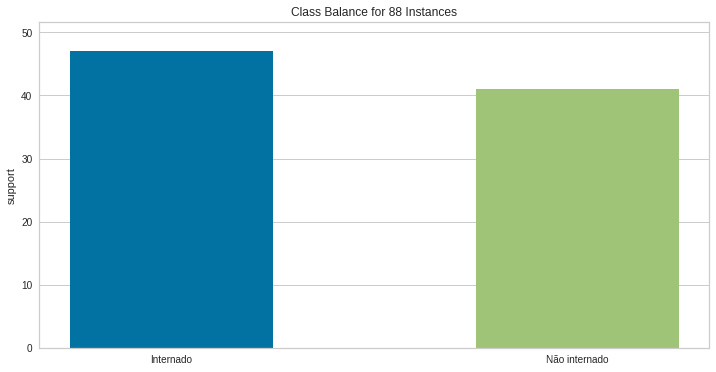

In [99]:
balanceamento_classes(dados_limpos)

In [100]:
modelo_logistic_regression_dados_limpos = LogisticRegression(max_iter=1000000)

In [101]:
acuracia(dados_limpos_sem_corr, modelo_logistic_regression_dados_limpos)

A acurácia do Modelo Logístico para dados_limpos é de : 65.91 %


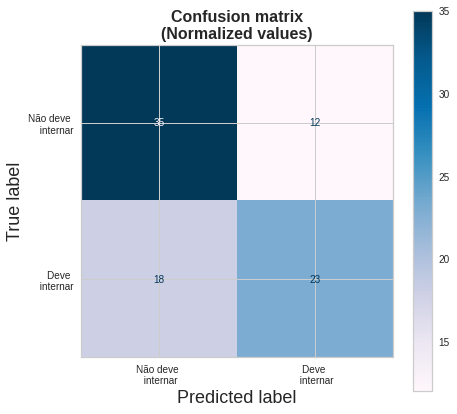

In [102]:
plote_confusion_matrix(dados_limpos_sem_corr, modelo_logistic_regression_dados_limpos )

In [103]:
roda_modelo(modelo_logistic_regression_dados_limpos, dados_limpos_sem_corr )

AUC: 0.8038401660612351

Classification Report
              precision    recall  f1-score   support

           0       0.75      0.77      0.76        47
           1       0.72      0.71      0.72        41

    accuracy                           0.74        88
   macro avg       0.74      0.74      0.74        88
weighted avg       0.74      0.74      0.74        88



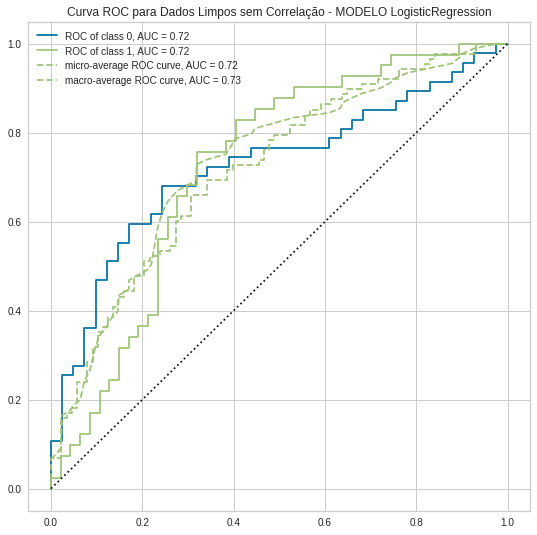

In [104]:
plotar_roc_auc(modelo_logistic_regression_dados_limpos, dados_limpos_sem_corr, "Dados Limpos sem Correlação")

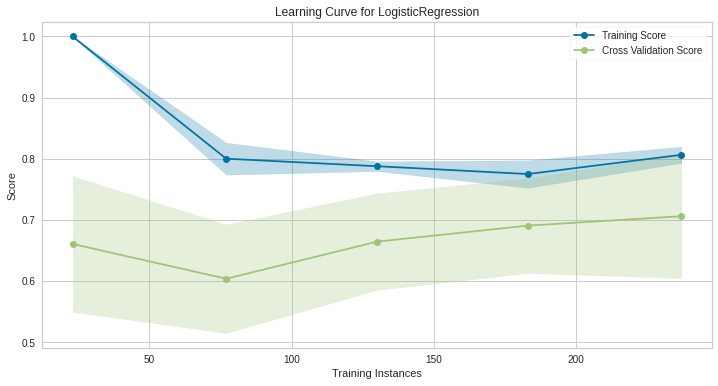

In [105]:
curve_of_learning(modelo_logistic_regression_dados_limpos, dados_limpos_sem_corr)

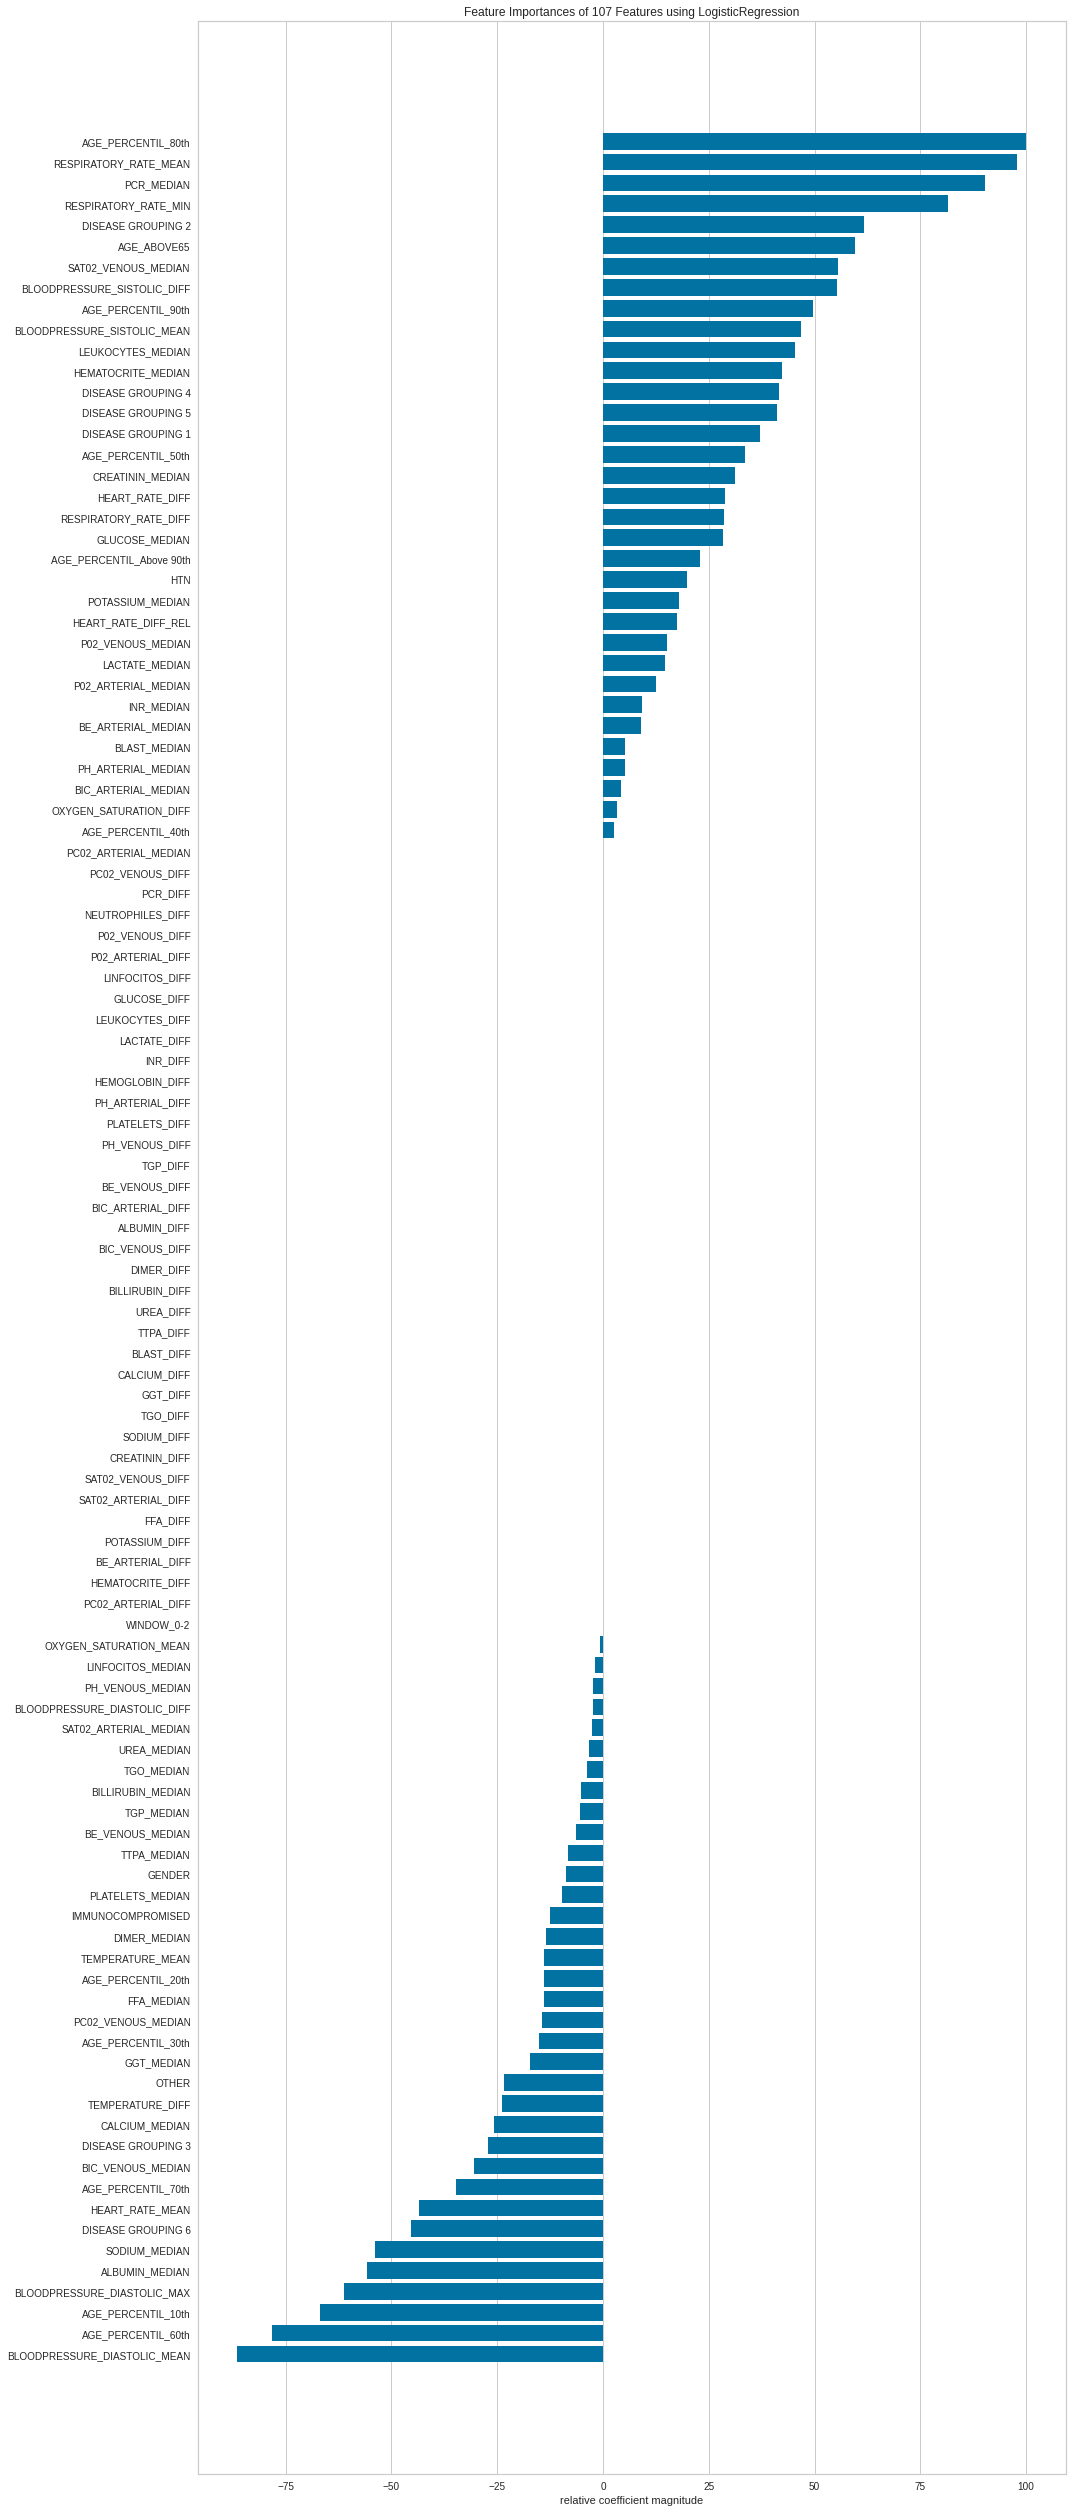

In [106]:
plotar_FeatureImportances(dados_limpos_sem_corr, modelo_logistic_regression_dados_limpos)

### DecisionTree

In [107]:
decision_tree_dados_limpos_sem_corr = DecisionTreeClassifier()

In [108]:
acuracia(dados_limpos_sem_corr, decision_tree_dados_limpos_sem_corr)

A acurácia do Modelo Logístico para dados_limpos é de : 61.36 %


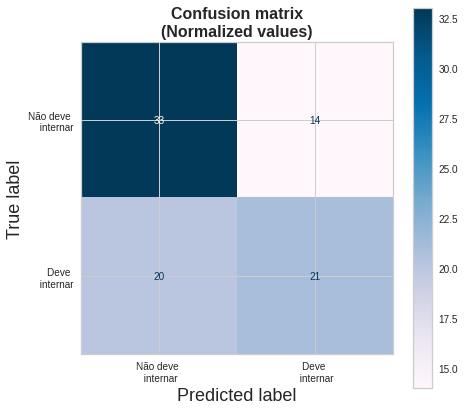

In [109]:
plote_confusion_matrix(dados_limpos_sem_corr, decision_tree_dados_limpos_sem_corr)

In [110]:
roda_modelo(decision_tree_dados_limpos_sem_corr, dados_limpos_sem_corr )

AUC: 0.6696938245978206

Classification Report
              precision    recall  f1-score   support

           0       0.70      0.68      0.69        47
           1       0.64      0.66      0.65        41

    accuracy                           0.67        88
   macro avg       0.67      0.67      0.67        88
weighted avg       0.67      0.67      0.67        88



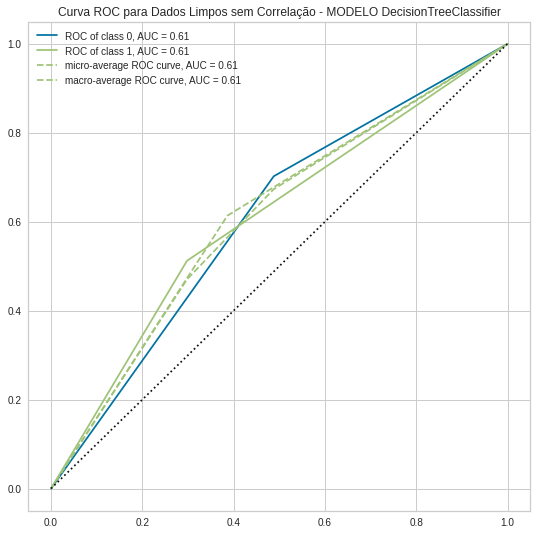

In [111]:
plotar_roc_auc(decision_tree_dados_limpos_sem_corr, dados_limpos_sem_corr, "Dados Limpos sem Correlação")

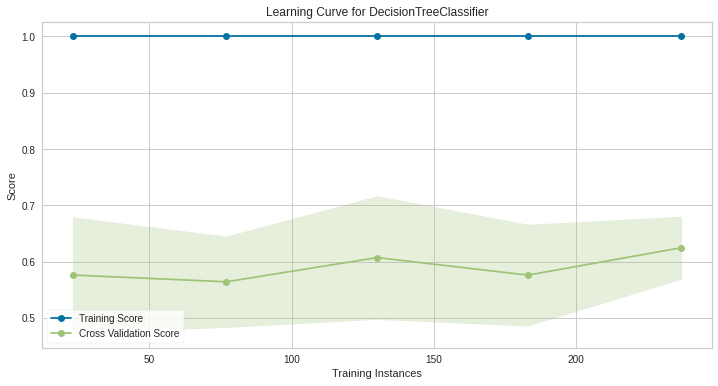

In [113]:
curve_of_learning(decision_tree_dados_limpos_sem_corr, dados_limpos_sem_corr)

DUMMYCLASSIFIER

In [114]:
modelo_dummyclassifier_dados_limpos_sem_corr = DummyClassifier()

In [115]:
acuracia(dados_limpos_sem_corr, modelo_dummyclassifier_dados_limpos_sem_corr)

A acurácia do Modelo Logístico para dados_limpos é de : 45.45 %


FORESTRANDOM

In [116]:
modelo_random_forest_dados_limpos_sem_corr = RandomForestClassifier(n_estimators=100)

In [117]:
acuracia(dados_limpos_sem_corr, modelo_random_forest_dados_limpos_sem_corr)

A acurácia do Modelo Logístico para dados_limpos é de : 65.91 %


# **CONCLUSÃO**